# Explore differences between CEH-GEAR and HadUK-Grid

In [150]:
import numpy as np
import polars as pl
import geopandas as gpd
import xarray as xr
import rioxarray

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats


In [2]:
RAIN_COL = "rain_mm"

EASTING_RANGE = [276000, 320500] ## based on data I have
NORTHING_RANGE = [258000, 301500] ## based on data I have

# Load data

## Load CEH-GEAR

In [3]:
ceh_plynlimon = xr.open_dataset('../../../CEH_GEAR/ceh_1km_plynlimonregion_19760101_20101231.nc')
ceh_plynlimon = ceh_plynlimon.rename({'rainfall_amount': RAIN_COL})

## Load HadUK-Grid

In [4]:
haduk_plynlimon = xr.open_mfdataset(['../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19760101_19920831.nc',\
                 '../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19920901_20091231.nc'])
haduk_plynlimon = haduk_plynlimon.rename({'rainfall': RAIN_COL, 'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
haduk_plynlimon = haduk_plynlimon.drop_vars(('latitude', 'longitude'))
haduk_plynlimon['time'] = haduk_plynlimon['time'].dt.floor(freq='D')

## Load HGHT grid

In [5]:
severn_hght = rioxarray.open_rasterio('../../../Spatial Data/HGHT_SEVERN_1km_CEHGrid.tif')
severn_hght = severn_hght.sortby('y')
severn_hght = severn_hght.sel(band=1)

severn_hght = severn_hght.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load gauge metadata

In [6]:
## monthly gauges
plynlimon_monthly_gauges = pl.read_csv('../gauge_data/mo_monthly_gauges_plynlimon.csv', try_parse_dates=True)

In [7]:
# daily metadata
plynlimon_metadata = pl.read_csv('../gauge_data/mo_plynlimon_area_metadata.csv')
plynlimon_metadata = plynlimon_metadata.with_columns(
    pl.col("ID").is_in(plynlimon_monthly_gauges['ID']).alias('IS_MONTHLY_GAUGE')
)

In [8]:
## Load gauge data (QC'd version)
plynlimon_all_gauges = pl.read_csv('../gauge_data/mo_daily_plynlimon_gauges.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])

# Load shapefiles (optional)

In [9]:
plynlimon_shp = gpd.read_file('../plynlimon_catchment_boundary/54022/54022.shp')
bewdley_shp = gpd.read_file('../../FDRI-catchment-contribution-to-floods/River Severn/Catchment_Data/Bewdley/54001/54001.shp')

# Shift grid

In [10]:
def coerse_data_into_haduk_format(data, offset, xrange, yrange):
    """
    Quick fix for coersing data to have same grid as HADUK.
    """
    data = data.assign_coords(x=(data['x'] + offset))
    data = data.assign_coords(y=(data['y'] + offset))
    data = data.sel(x=xrange, y=yrange)
    return data


In [11]:
ceh_plynlimon_shifted = coerse_data_into_haduk_format(ceh_plynlimon, offset=500, xrange=slice(*EASTING_RANGE), yrange=slice(*NORTHING_RANGE))

In [12]:
ceh_plynlimon_shifted['hght'] = severn_hght

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

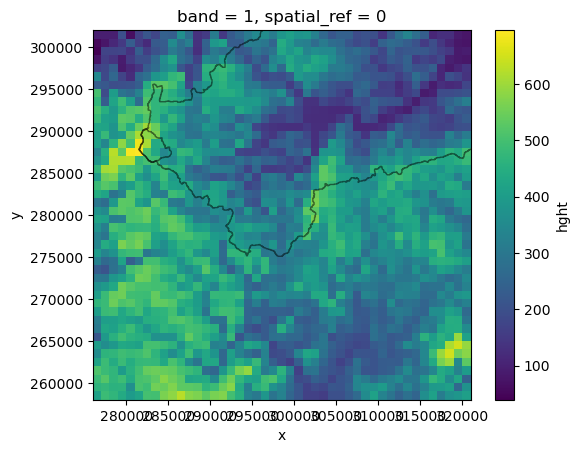

In [13]:
fig, ax = plt.subplots(1)
(ceh_plynlimon_shifted['hght']/10).plot(ax=ax)
plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
bewdley_shp.plot(ax=ax, facecolor='none', alpha=.5)

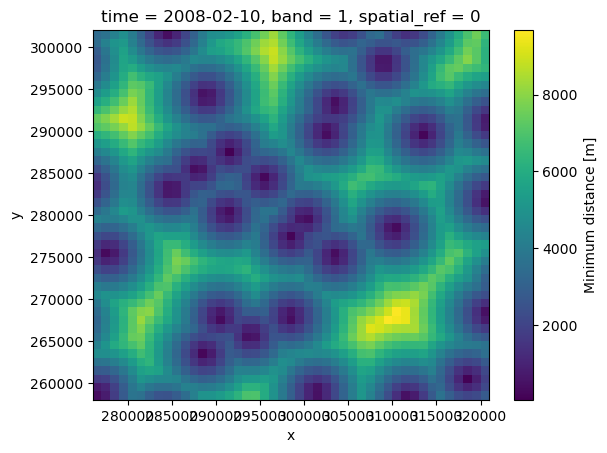

In [14]:
ceh_plynlimon_shifted['min_dist'].sel(time="2008-02-10").plot()

# Get difference between HadUK to CEH-GEAR

In [15]:
ceh_plynlimon_shifted = ceh_plynlimon_shifted.sel(time=slice(haduk_plynlimon['time'].min(), haduk_plynlimon['time'].max()))

In [16]:
haduk_plynlimon['time'].min()

<xarray.DataArray 'time' ()> Size: 8B
array('1976-01-01T00:00:00.000000000', dtype='datetime64[ns]')

In [174]:
ceh_haduk_diff = ceh_plynlimon_shifted[RAIN_COL] - haduk_plynlimon[RAIN_COL]
diff_col_name = f'{RAIN_COL}_diff'
ceh_haduk_diff = ceh_haduk_diff.to_dataset(name=diff_col_name)
ceh_haduk_diff['hght'] = severn_hght
ceh_haduk_diff['min_dist'] = ceh_plynlimon_shifted['min_dist']

In [175]:
ceh_haduk_diff.load()

<xarray.Dataset> Size: 394MB
Dimensions:       (time: 12419, x: 45, y: 44)
Coordinates:
  * time          (time) datetime64[ns] 99kB 1976-01-01 ... 2009-12-31
  * x             (x) float64 360B 2.765e+05 2.775e+05 ... 3.195e+05 3.205e+05
  * y             (y) float64 352B 2.585e+05 2.595e+05 ... 3.005e+05 3.015e+05
    band          int64 8B 1
    spatial_ref   int64 8B 0
Data variables:
    rain_mm_diff  (time, y, x) float64 197MB -6.509 -7.838 ... 0.1468 0.0996
    hght          (y, x) int32 8kB 4139 4855 4692 4372 ... 1277 1272 881 756
    min_dist      (time, y, x) float64 197MB 7.916e+03 8.041e+03 ... 6.631e+03

In [176]:
ceh_haduk_diff[diff_col_name].min(), ceh_haduk_diff[diff_col_name].max()

(<xarray.DataArray 'rain_mm_diff' ()> Size: 8B
 array(-65.64007871)
 Coordinates:
     band         int64 8B 1
     spatial_ref  int64 8B 0,
 <xarray.DataArray 'rain_mm_diff' ()> Size: 8B
 array(70.70480083)
 Coordinates:
     band         int64 8B 1
     spatial_ref  int64 8B 0)

# Explore differences between gridded datasets

<Axes: title={'center': 'CEH-GEAR vs HadUK-Grid'}, xlabel='x', ylabel='y'>

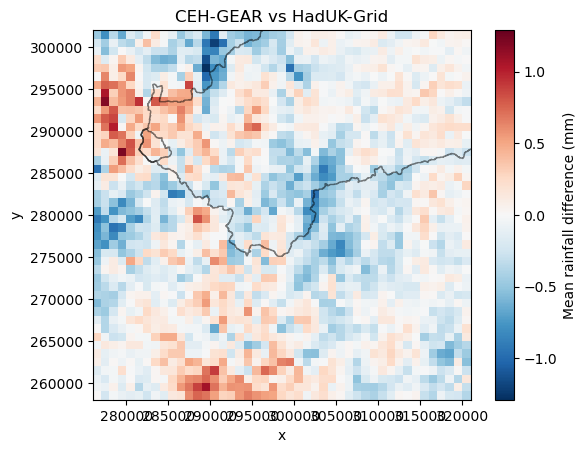

In [177]:
fig, ax = plt.subplots(1)
ceh_haduk_diff[diff_col_name].mean('time').plot(ax=ax, cmap='RdBu_r', cbar_kwargs={'label':'Mean rainfall difference (mm)'})
ax.set_title("CEH-GEAR vs HadUK-Grid")
plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
bewdley_shp.plot(ax=ax, facecolor='none', alpha=.5)

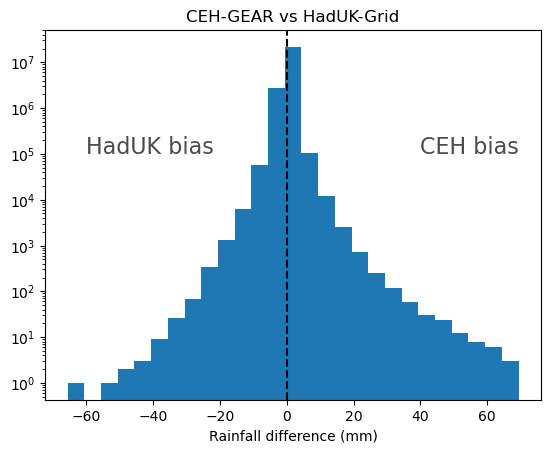

In [178]:
fig, ax = plt.subplots(1)
ceh_haduk_diff[diff_col_name].plot(ax=ax, bins=np.arange(ceh_haduk_diff[diff_col_name].min(), ceh_haduk_diff[diff_col_name].max(), 5))
ax.set_yscale('log')
ax.set_title("CEH-GEAR vs HadUK-Grid")
ax.set_xlabel("Rainfall difference (mm)")
ax.text(s="CEH bias", x=40, y=100000, color='k', alpha=.7, size=16)
ax.text(s="HadUK bias", x=-60, y=100000, color='k', alpha=.7, size=16)
ax.axvline(0, linestyle='--', color='k')

### Annual mean

In [179]:
annual_ceh_haduk_diff = ceh_haduk_diff.groupby('time.year').mean()

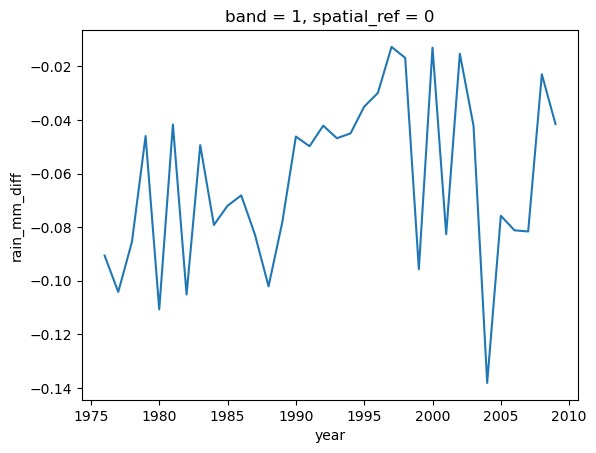

In [180]:
annual_ceh_haduk_diff[diff_col_name].mean(('x', 'y')).plot()

### by season

In [181]:
seasonal_ceh_haduk_diff = ceh_haduk_diff.groupby('time.season').mean()

Text(0.5, 1, 'CEH-GEAR vs HadUK-Grid')

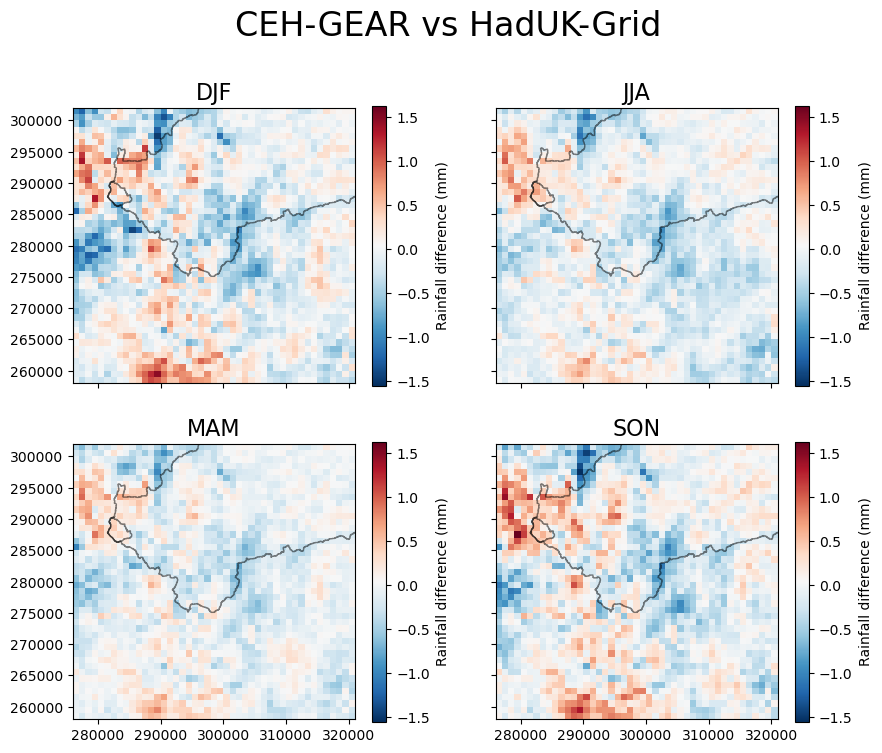

In [182]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
for season, ax in zip(seasonal_ceh_haduk_diff['season'], axes.flatten()):
    seasonal_ceh_haduk_diff[diff_col_name].sel(season=season).plot(ax=ax, vmin=seasonal_ceh_haduk_diff[diff_col_name].min(), vmax=seasonal_ceh_haduk_diff[diff_col_name].max(),\
        cmap='RdBu_r', cbar_kwargs={'label':'Rainfall difference (mm)'})
    plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
    bewdley_shp.plot(ax=ax, facecolor='none', alpha=.5)
    ax.set_title(str(season.data), size=16)
    ax.set_xlabel(''); ax.set_ylabel('')
fig.suptitle('CEH-GEAR vs HadUK-Grid', size=24, y=1)

### by month

In [183]:
monthly_ceh_haduk_diff = ceh_haduk_diff.groupby('time.month').mean()

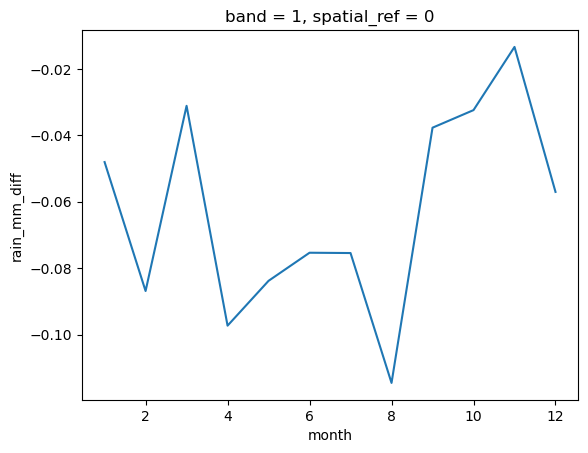

In [184]:
monthly_ceh_haduk_diff[diff_col_name].mean(('x', 'y')).plot()

### topography vs rainfall

In [200]:
ceh_haduk_diff_mean = ceh_haduk_diff.mean('time')

In [304]:
def plot_scatter_w_regline(x, y, ax):
    linreg_coef = np.polyfit(x, y, deg=1)
    linreg_func = np.poly1d(linreg_coef)
    rval, pval = scipy.stats.pearsonr(x, y)
    ax.scatter(x, y)
    ax.plot(x, y, 'o', linreg_func(np.arange(x.min(), x.max())))
    ax.text(s=f'r={rval: .2f}\np={pval: .2f}', x=0, y=1)
    return ax


def plot_quadrat_count_plot(x, y, ax,  num_quadrats=6):
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    y_max = max(y_max, abs(y_min))
    x_bins = np.linspace(x_min, x_max, num_quadrats + 1)
    y_bins = np.linspace(-y_max, y_max, num_quadrats + 1)

    # Count points in each quadrat
    quadrat_counts = np.zeros((num_quadrats, num_quadrats))
    for i in range(num_quadrats):
        for j in range(num_quadrats):
            in_x_range = (x >= x_bins[i]) & (x < x_bins[i+1])
            in_y_range = (y >= y_bins[j]) & (y < y_bins[j+1])
            quadrat_counts[i, j] = np.sum(in_x_range & in_y_range)

    for x_bin in x_bins:
        ax.axvline(x_bin, color='gray', linestyle='--', alpha=0.6)
    for y_bin in y_bins:
        ax.axhline(y_bin, color='gray', linestyle='--', alpha=0.6)

    # Annotate quadrat counts
    for i in range(num_quadrats):
        for j in range(num_quadrats):
            ax.text((x_bins[i] + x_bins[i+1]) / 2,
                    (y_bins[j] + y_bins[j+1]) / 2,
                    int(quadrat_counts[i, j]),
                    color='red', fontsize=12, ha='center', va='center')

    return ax

<Axes: >

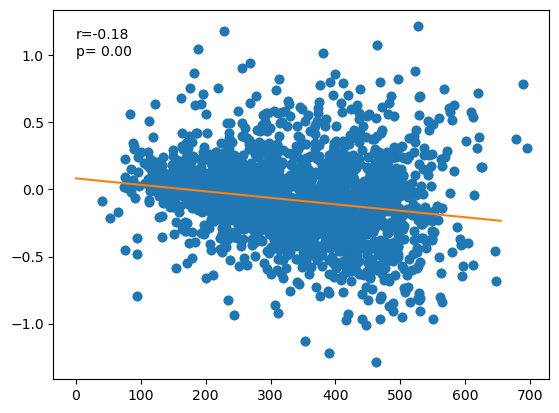

In [332]:
fig, ax = plt.subplots(1)
plot_scatter_w_regline(x, y, ax)


Text(0, 0.5, 'Rainfall difference (mm)')

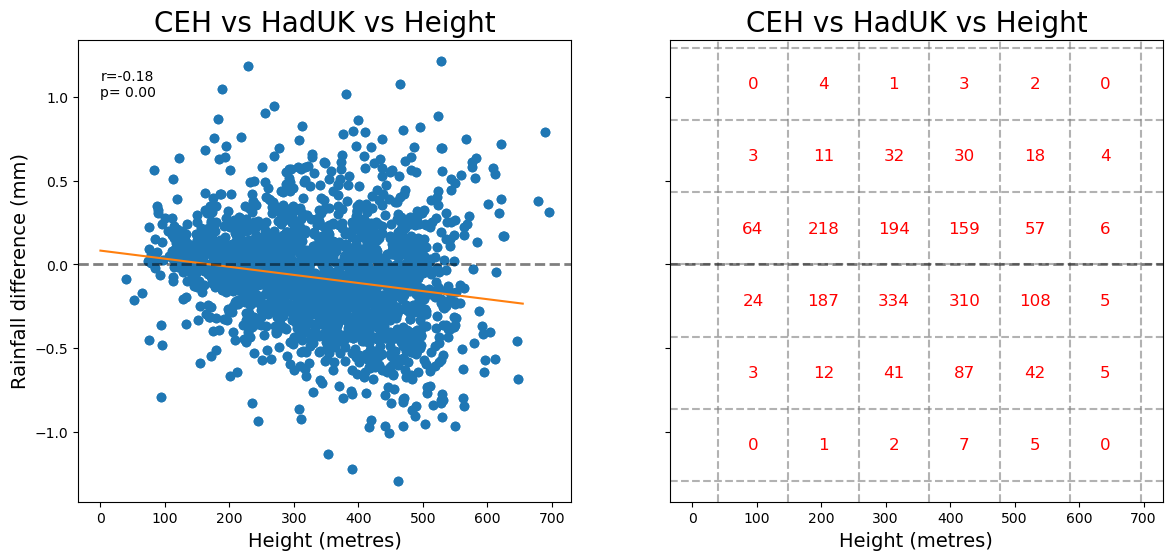

In [ ]:
x = (ceh_haduk_diff_mean['hght']/10).data.flatten()
y = ceh_haduk_diff_mean['rain_mm_diff'].data.flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
plot_scatter_w_regline(x, y, axes[0])
plot_quadrat_count_plot(x, y, axes[1])
for ax in axes:
    ax.set_title("CEH vs HadUK vs Height", size=20)
    ax.set_xlabel("Height (metres)", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)

axes[0].set_ylabel("Rainfall difference (mm)", size=14)

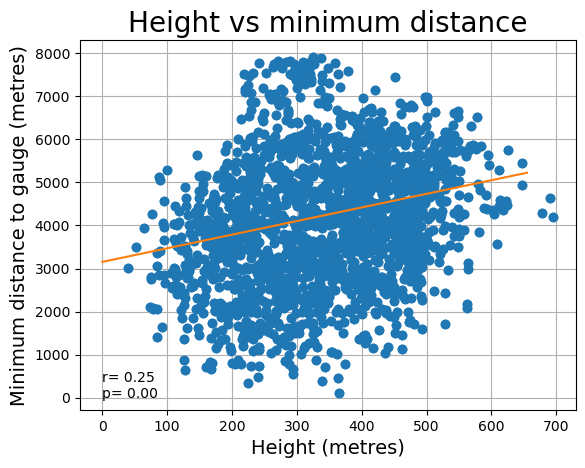

In [309]:
x = (ceh_haduk_diff_mean['hght']/10).data.flatten()
y = ceh_haduk_diff_mean['min_dist'].data.flatten()
fig, ax = plt.subplots(1)
plot_scatter_w_regline(x, y, ax)
ax.set_title("Height vs minimum distance", size=20)
ax.set_xlabel("Height (metres)", size=14)
ax.set_ylabel("Minimum distance to gauge (metres)", size=14)
ax.grid()

In [355]:
print(f'Total of {int((ceh_haduk_diff_mean['rain_mm_diff'] > 0).sum().data)} grid cells where CEH > HadUK\nTotal of {int((ceh_haduk_diff_mean['rain_mm_diff'] < 0).sum().data)} grid cells where CEH < HadUK')

Total of 807 grid cells where CEH > HadUK
Total of 1173 grid cells where CEH < HadUK


Text(0, 0.5, 'Rainfall difference (mm)')

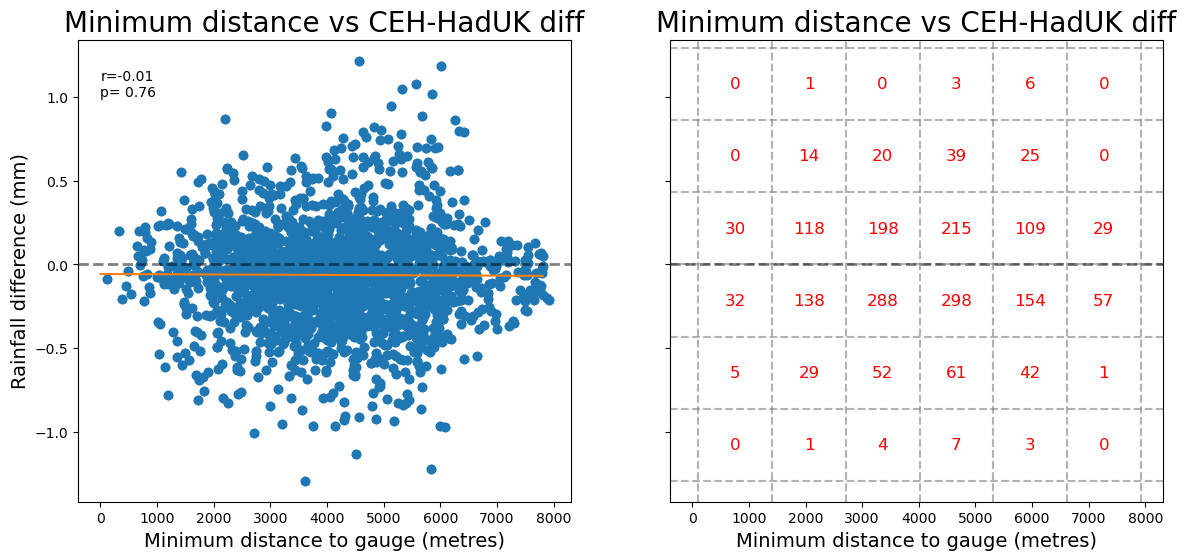

In [356]:
x = ceh_haduk_diff_mean['min_dist'].data.flatten()
y = ceh_haduk_diff_mean['rain_mm_diff'].data.flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
plot_scatter_w_regline(x, y, axes[0])
plot_quadrat_count_plot(x, y, axes[1])
for ax in axes:
    ax.set_title("Minimum distance vs CEH-HadUK diff", size=20)
    ax.set_xlabel("Minimum distance to gauge (metres)", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)

axes[0].set_ylabel("Rainfall difference (mm)", size=14)

## by season

Text(0.5, 1, 'CEH vs HadUK vs Height')

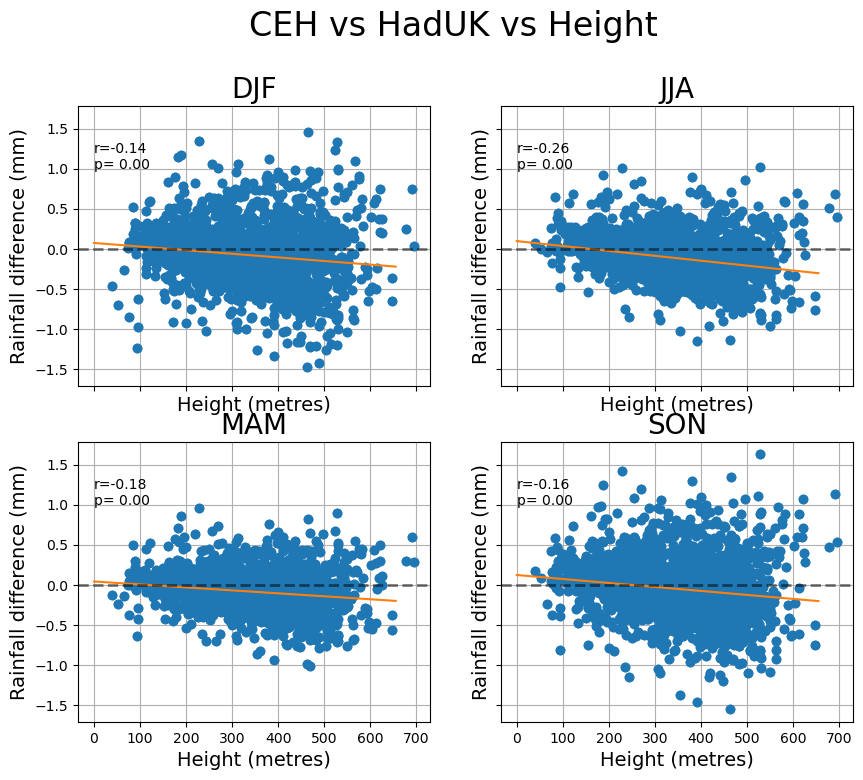

In [337]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
for season, ax in zip(seasonal_ceh_haduk_diff['season'], axes.flatten()):
    x = (seasonal_ceh_haduk_diff.sel(season=season)['hght']/10).data.flatten()
    y = seasonal_ceh_haduk_diff.sel(season=season)['rain_mm_diff'].data.flatten()
    ax = plot_scatter_w_regline(x, y, ax)
    # plot_quadrat_count_plot(x, y, ax)
    ax.set_title(str(season.data), size=20)
    ax.set_xlabel("Height (metres)", size=14)
    ax.set_ylabel("Rainfall difference (mm)", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)

    ax.grid()
fig.suptitle('CEH vs HadUK vs Height', size=24, y=1)